In [6]:
!pip install transformers --upgrade
!pip install sentencepiece


In [7]:
!pip install transformers sentencepiece datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00


In [8]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [30]:
from transformers import AutoModelForSeq2SeqLM

model_repo = 'google/mt5-small'  # Define model_repo before using it
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)

max_seq_len = model.config.max_length
device = torch.device("cuda")

model = model.to(device)


In [11]:
pip install sentencepiece


In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [31]:
input_sent = 'Here is our test sentence!'
token_ids = tokenizer.encode(input_sent, return_tensors='pt')
token_ids

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

RuntimeError: ignored

In [22]:
dataset = load_dataset('alt')

Generating train split:   0%|          | 0/18088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

In [32]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [33]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [34]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt',
    padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

NameError: ignored

In [35]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [36]:
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

▁< jp > 意大利 在 法国 巴黎 王子 公园 体育 场 举办 的 2007 年 橄 榄 球 世界杯 C 组 以 3 1-5 击 败 葡萄 牙 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ フランス の パリ 、 パル ク ・ デ ・ プラン ス で 行われた 2007 年 ラグビー ワールド カップ の プール C で 、 イタリア は 31 対 5 で ポル ト ガル を下 した 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [37]:
n_epochs = 5
batch_size = 10
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [38]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [40]:
test_loss = eval_model(model, test_dataset)


In [44]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):

    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()


    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

  test_loss = eval_model(model, test_dataset)
  print('Test loss of {:.3f}'.format(test_loss))

<ipython-input-44-7e1499948fa3>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/1809 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 2.655 | lr: 0.00018877721943048577
Epoch: 1 | Step: 100 | Avg. loss: 2.607 | lr: 0.0001859854829704076
Epoch: 1 | Step: 150 | Avg. loss: 2.613 | lr: 0.00018319374651032944
Epoch: 1 | Step: 200 | Avg. loss: 2.578 | lr: 0.00018040201005025127
Epoch: 1 | Step: 250 | Avg. loss: 2.592 | lr: 0.0001776102735901731


KeyboardInterrupt: ignored

In [42]:
losses =[]

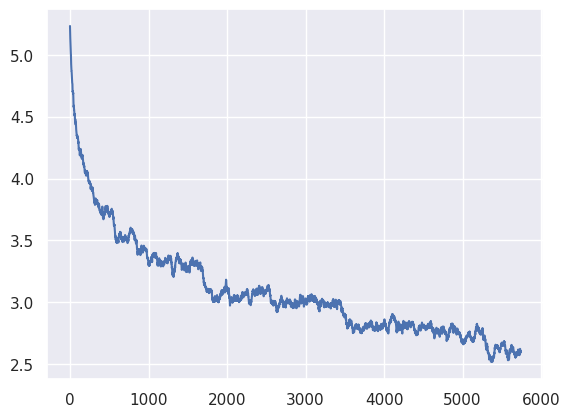

In [45]:
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [46]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp>It has been confirmed that eight thoroughbred race horses at Randwick</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

In [48]:
# Provided information
sentence_0 = "It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza."

# Given sequence with placeholders
sequence = "<extra_id_0> <extra_id_0>. <extra_id_0>.) <extra_id_10>.едет <extra_id_10> <extra_id_10>)on.on bulunduарамен次次ان次وا"

# Replace the placeholders with actual content
filled_sequence = sequence.replace("<extra_id_0>", sentence_0)
filled_sequence = filled_sequence.replace("<extra_id_10>", sentence_0)

print("Filled Sequence:", filled_sequence)

Filled Sequence: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza. It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.. It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza..) It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza..едет It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza. It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.)on.on bulunduарамен次次ان次وا


In [49]:
import nltk

def calculate_wer(reference, candidate):
    """
    Calculate Word Error Rate (WER) between reference and candidate.
    :param reference: list of reference words
    :param candidate: list of candidate words
    :return: Word Error Rate
    """
    align = nltk.edit_distance(reference, candidate)
    wer = align / len(reference)
    return wer

# Example usage:
reference_translation = ["your name"]
candidate_translation = ["Your name was asked, “What is your name?"]

wer_score = calculate_wer(reference_translation, candidate_translation)
print(f"Word Error Rate: {wer_score}")

Word Error Rate: 1.0


In [50]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [51]:
reference = ["your name"]
candidate = 'Your name was asked, “What is your name?”'

# Tokenize the sentences
reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
candidate_tokens = nltk.word_tokenize(candidate)

# Calculate BLEU score
bleu_score = sentence_bleu(reference_tokens, candidate_tokens)

print("BLEU Score:", bleu_score)

BLEU Score: 5.233427736988301e-155


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [53]:
pip install rouge

In [54]:
from rouge import Rouge

# Reference (ground truth) and candidate (generated) sentences
reference = ["your name"]
candidate = "Your name was asked, 'What is your name?'"

# Convert the reference list to a string
reference_str = ' '.join(reference)

# Initialize the Rouge object
rouge = Rouge()

# Calculate ROUGE scores
scores = rouge.get_scores(candidate, reference_str)

# Print the ROUGE scores
print("ROUGE Scores:")
print("ROUGE-1 Precision:", scores[0]["rouge-1"]["p"])
print("ROUGE-1 Recall:", scores[0]["rouge-1"]["r"])
print("ROUGE-1 F1 Score:", scores[0]["rouge-1"]["f"])

print("ROUGE-2 Precision:", scores[0]["rouge-2"]["p"])
print("ROUGE-2 Recall:", scores[0]["rouge-2"]["r"])
print("ROUGE-2 F1 Score:", scores[0]["rouge-2"]["f"])

print("ROUGE-L Precision:", scores[0]["rouge-l"]["p"])
print("ROUGE-L Recall:", scores[0]["rouge-l"]["r"])
print("ROUGE-L F1 Score:", scores[0]["rouge-l"]["f"])

ROUGE Scores:
ROUGE-1 Precision: 0.25
ROUGE-1 Recall: 1.0
ROUGE-1 F1 Score: 0.39999999680000003
ROUGE-2 Precision: 0.0
ROUGE-2 Recall: 0.0
ROUGE-2 F1 Score: 0.0
ROUGE-L Precision: 0.125
ROUGE-L Recall: 0.5
ROUGE-L F1 Score: 0.19999999680000002


In [55]:
import nltk

# Download the WordNet dataset
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [56]:
import nltk
from nltk.translate import meteor_score

# Download the WordNet dataset
nltk.download('wordnet')

# Reference (ground truth) and candidate (generated) sentences
reference = ["your name"]
candidate = "Your name was asked, 'What is your name?'"

# Tokenize the sentences
reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
candidate_tokens = nltk.word_tokenize(candidate)

# Calculate METEOR score
meteor_score_value = meteor_score.meteor_score(reference_tokens, candidate_tokens)

# Print the METEOR score
print("METEOR Score:", meteor_score_value)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


METEOR Score: 0.646551724137931
